In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, kalman_filter, make_FXHedge, ridge_regression
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True, dayfirst=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

#fx
EUR_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']
GBP_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['GBP/USD']

# HFRX

#bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BPFXEUR1', 'BPFXGBP1']]

bnp_all = pd.read_csv(r"financial_data/bnp_risk_premia_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIF3XM', 'BNPIFXMG',
                                                                                                                'BNPIPMEE', 'BNPIPMUH',
                                                                                                                'BNPIMDEA']]
bnp_all = bnp_all.reindex(US_rate.index).dropna()
bnp_all = make_FXHedge(bnp_all, EUR_USD_fx)
#bnp_all = bnp_all.join(bnp, how="outer")
#bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFUS', 'BNPIFUSC',
#                            'BNPIFJP', 'BNPIFGB', 'BNPIFCH', 'BNPIFEM', 'BPFXEUR1', 'BPFXGBP1', 'BPFXJPY1']]

hfrx_all = pd.read_csv(r"financial_data/NEIXCTAT.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
#hfrx_all = hfrx_all.loc[US_rate.index].dropna()

hfrx_all = hfrx_all.reindex(bnp_all.index).dropna()
hfrx_all = make_ER(hfrx_all.dropna(), US_rate)

In [4]:
prices_all = bnp_all.copy()
#prices = prices.join(msci, how="outer")
prices_all = prices_all.join(hfrx_all,how="outer").dropna()

In [5]:
prices_all = prices_all.ffill().dropna()
returns_all = prices_all.resample('7D').first().pct_change().dropna()

In [6]:
hrfx_returns = returns_all[["NEIXCTAT Index"]]
bch_returns_all = returns_all.drop("NEIXCTAT Index", axis=1)

size = 52
freq = 4

df_weight = ols_regression(hrfx_returns, bch_returns_all, size, freq)

prices_for_track = prices_all.loc[df_weight.index[0]:].drop("NEIXCTAT Index", axis=1)
replication = make_track(prices_for_track, df_weight)

df_res = prices_all.loc[replication.index][["NEIXCTAT Index"]]
df_res["OLS all"] = replication

In [7]:
df_weight_lasso = lasso_regression(hrfx_returns, bch_returns_all, size, freq, l=5e-5)
replication_lasso = make_track(prices_for_track, df_weight_lasso)
df_res["Lasso"] = replication_lasso

In [8]:
df_weight_ridge =ridge_regression(hrfx_returns, bch_returns_all, size, freq, l=1e-3)
replication_ridge = make_track(prices_for_track, df_weight_ridge)
df_res["Ridge"] = replication_ridge

In [9]:
df_weight_kalman = kalman_filter(hrfx_returns, bch_returns_all, 1, sigma_weight=0.1, sigma_return=0.005)
prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:].drop("NEIXCTAT Index", axis=1)
replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_weight.index[0]:]
df_res["Kalman"] = replication_kalman

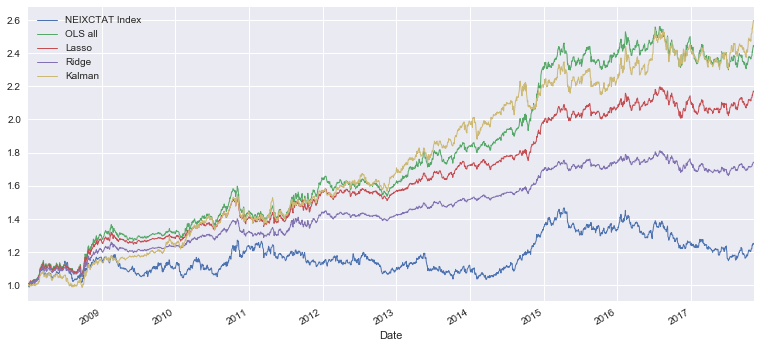

In [10]:
df_res = df_res / df_res.iloc[0]
df_res.plot(figsize=(13,6), linewidth=1)

In [11]:
g = hc_stock(df_res)
g.plot()

In [12]:
Returns = df_res.pct_change().dropna()
Returns.corr(method='pearson')

,NEIXCTAT Index,OLS all,Lasso,Ridge,Kalman
NEIXCTAT Index,1.000000,0.631451,0.627395,0.617518,0.629462
OLS all,0.631451,1.000000,0.977108,0.973823,0.868842
Lasso,0.627395,0.977108,1.000000,0.980584,0.849051
Ridge,0.617518,0.973823,0.980584,1.000000,0.841403
Kalman,0.629462,0.868842,0.849051,0.841403,1.000000


In [13]:
returns_track = df_res.pct_change().dropna()
feu = returns_track['NEIXCTAT Index']
returns_track = returns_track.drop('NEIXCTAT Index', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (feu.values - returns_track.T).std(axis=1)
df

,Tracking error
OLS all,0.005671
Lasso,0.005485
Ridge,0.005535
Kalman,0.005842


In [14]:
returns_track = df_res.pct_change().dropna()
feu = returns_track['NEIXCTAT Index']
returns_track = returns_track.drop('NEIXCTAT Index', axis=1)
df_2 = pd.DataFrame()
df_2['Average error'] = (np.abs(feu.values - returns_track.T)).mean(axis=1)
df_2

,Average error
OLS all,0.004265
Lasso,0.004084
Ridge,0.004135
Kalman,0.004406


In [15]:
(Returns.mean() / Returns.std()) * np.sqrt(252)

NEIXCTAT Index    0.261035
OLS all           1.010481
Lasso             1.066248
Ridge             0.961256
Kalman            1.004389
dtype: float64

In [16]:
weight = pd.DataFrame(data={'Lasso': np.abs(df_weight_lasso).mean(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', np.abs(df_weight_all).mean(axis=0))
weight['Ridge'] = np.abs(df_weight_ridge).mean(axis=0)
weight['Kalman'] = np.abs(df_weight_kalman).mean(axis=0)
ax = weight.plot(kind='bar', title='Average absolute exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

NameError: name 'df_weight_all' is not defined